<a href="https://colab.research.google.com/github/HThinhZ/PPA_Project/blob/main/PPA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Parallel Programming Application Project:**
# **Parallel KMeans: Credit Card Segmentation**



> # *1. Giới thiệu:*

> ## **Thông tin nhóm:**


| MSSV     | Họ và tên             | Email    |
| :-----:  | :--------:            | :-------:|
| 20120481 | Phan Xuân Hoài        | 20120481@student.hcmus.edu.vn|
| 20120587 | Nguyễn Hoàng Thịnh    | 20120587@student.hcmus.edu.vn|

> ## **Mô tả bài toán:**

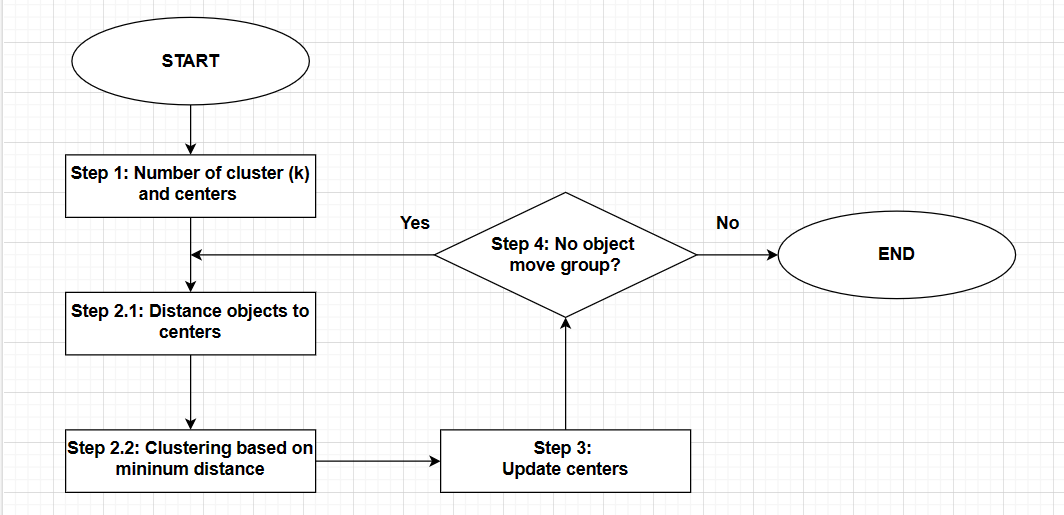

Quy trình thực hiện chi tiết của thuật toán KMeans:

+ Bước 1: Khởi tạo các điểm trung tâm ban đầu
  + Chọn số lượng cụm cần phân chia (k).
  + Khởi tạo ngẫu nhiên k điểm dữ liệu từ tập dữ liệu ban đầu làm các điểm trung tâm ban đầu (centers) của các cụm. (Ở đây nhóm em lấy k điểm dữ liệu đầu tiên trong bộ dữ liệu)
+ Bước 2: Phân loại các điểm dữ liệu vào các cụm **(Song Song)**
  + Tính toán khoảng cách (Sử dụng khoảng cách Euclide) giữa mỗi điểm dữ liệu và tất cả các điểm trung tâm.
  + Gán mỗi điểm dữ liệu vào cụm có điểm trung tâm gần nhất.
+ Bước 3: Cập nhật vị trí của các điểm trung tâm **(Song Song)**
  + Tính toán lại vị trí của các điểm trung tâm bằng cách lấy trung bình của tất cả các điểm dữ liệu trong cùng một cụm.
+ Bước 4: Lặp lại các bước 2 và 3
  + Lặp lại các bước 2 và 3 cho đến khi không có sự thay đổi nào trong vị trí của các điểm trung tâm hoặc sau một số lần lặp cố định.
+ Bước 5: Kết thúc và đánh giá kết quả
  + Kết thúc vòng lặp ta sẽ thu được số lượng cụm dữ liệu với mỗi cụm dữ liệu có nét tương đồng với nhau


> # *2. Thực hiện đồ án:*

> ## **Install và import thư viện**

In [98]:
# Install libraries

In [99]:
# Import libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
import math
from numba import cuda, prange, jit
import numba
import warnings
warnings.filterwarnings(action="ignore")

In [100]:
# bảng thời gian
all_results = pd.DataFrame(columns=['time (s)'], dtype=float)
all_results

,time (s)


> ## **Đọc dữ liệu:**

In [101]:
!gdown https://drive.google.com/uc?id=1h4lv63HGrChaguGwtNtCYb7WPgb1Qnw3

Downloading...
From: https://drive.google.com/uc?id=1h4lv63HGrChaguGwtNtCYb7WPgb1Qnw3
To: /content/CC GENERAL.csv
100% 903k/903k [00:00<00:00, 10.2MB/s]


In [102]:
df = pd.read_csv("CC GENERAL.csv")
df

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


> ## **Khám phá dữ liệu**

### 1. Thông tin cơ bản

In [103]:
# Data shape
df.shape

(8950, 18)

In [104]:
# Xem thông tin của dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

#### **Nhận xét:**
Customer ID nên được xóa bỏ vì không phù hợp cho việc phân cụm (KMeans)

In [105]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


### 2. Data Schema

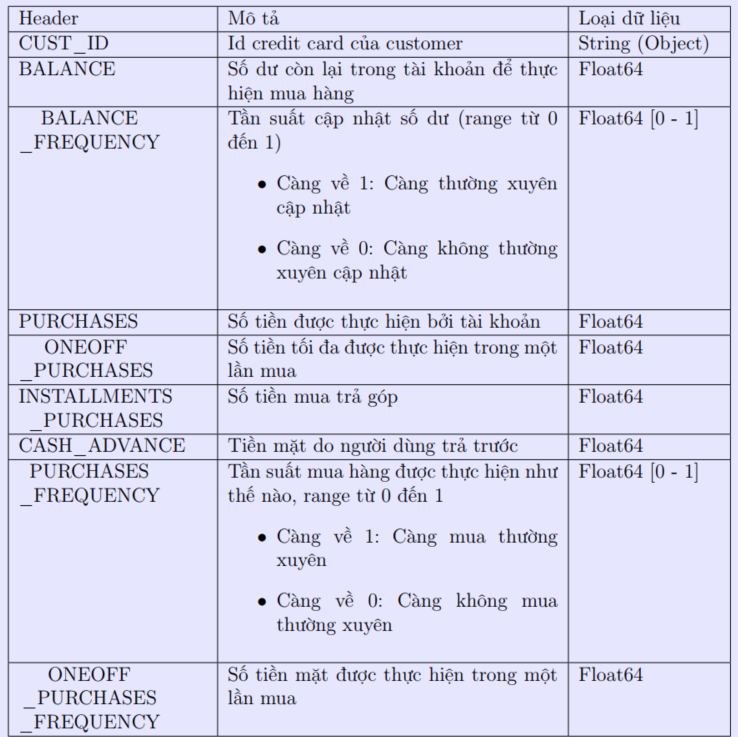


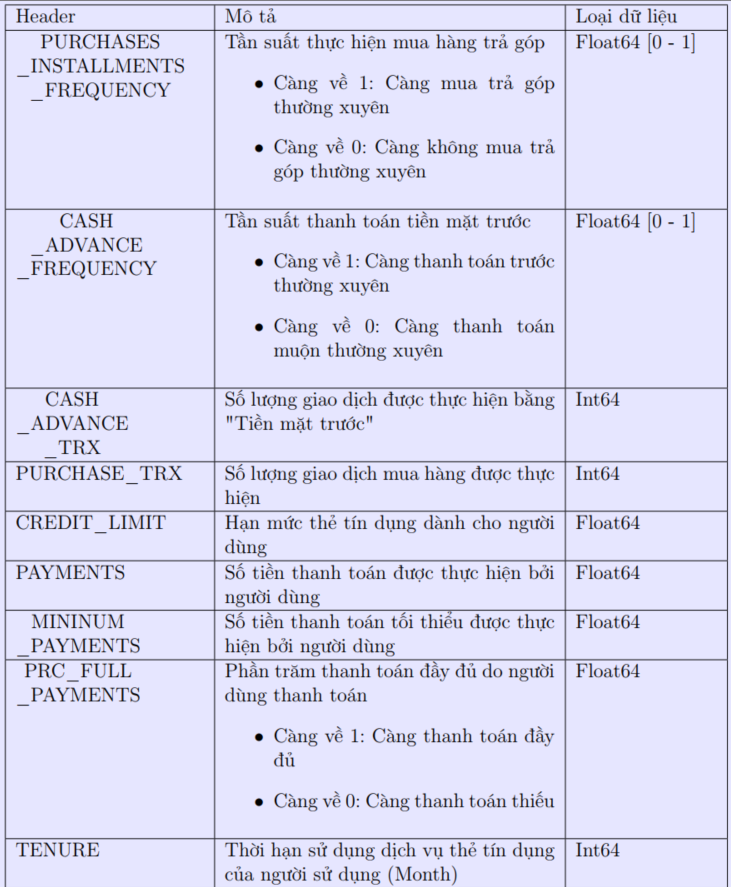

### 3. Kiếm tra những thông tin cần tiền xử lý



In [106]:
# Ta thấy ở df.info() có những cột có giá trị Nan, kiểm tra:
df.isnull().sum()


CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [107]:
## Cột "CREDIT_LIMIT"
df[df["CREDIT_LIMIT"].isnull()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5203,C15349,18.400472,0.166667,0.0,0.0,0.0,186.853063,0.0,0.0,0.0,0.166667,1,0,NaN,9.040017,14.418723,0.0,6


In [108]:
## Cột "MINIMUM_PAYMENTS"
df[df["MINIMUM_PAYMENTS"].isnull()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.0,12
45,C10047,2242.311686,1.000000,437.00,97.00,340.0,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.000000,NaN,0.0,12
47,C10049,3910.111237,1.000000,0.00,0.00,0.0,1980.873201,0.000000,0.000000,0.000000,0.500000,7,0,4200.0,0.000000,NaN,0.0,12
54,C10056,6.660517,0.636364,310.00,0.00,310.0,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,417.016763,NaN,0.0,12
55,C10057,1311.995984,1.000000,1283.90,1283.90,0.0,0.000000,0.250000,0.250000,0.000000,0.000000,0,6,6000.0,0.000000,NaN,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8919,C19160,14.524779,0.333333,152.00,152.00,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,1500.0,0.000000,NaN,0.0,6
8929,C19170,371.527312,0.333333,0.00,0.00,0.0,1465.407927,0.000000,0.000000,0.000000,0.166667,5,0,1500.0,0.000000,NaN,0.0,6
8935,C19176,183.817004,1.000000,465.90,0.00,465.9,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1500.0,0.000000,NaN,0.0,6
8944,C19185,193.571722,0.833333,1012.73,1012.73,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,4000.0,0.000000,NaN,0.0,6


In [109]:
# Kiểm tra tính trùng lặp
df[df.duplicated()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE


### 4. Kiểm tra các outliers

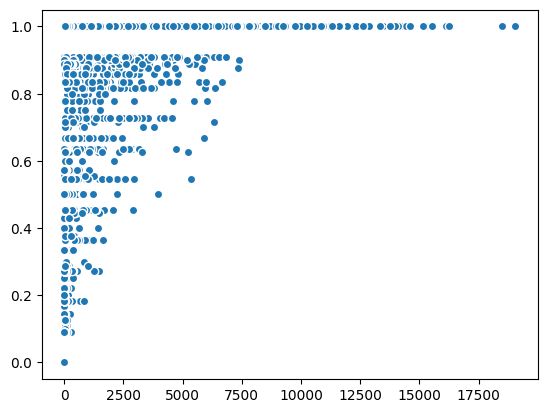

In [110]:
plt.scatter(df["BALANCE"], df["BALANCE_FREQUENCY"], edgecolors="white")

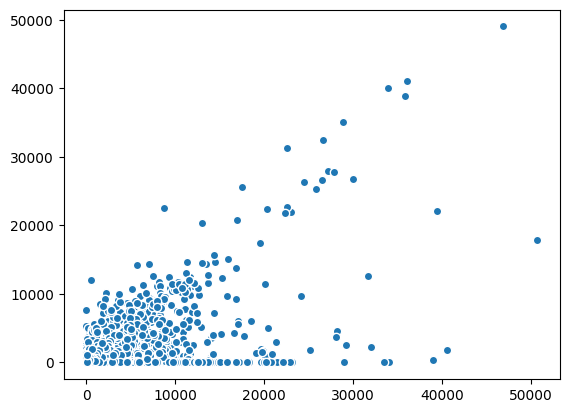

In [111]:
plt.scatter(df["PAYMENTS"], df["PURCHASES"], edgecolors="white")

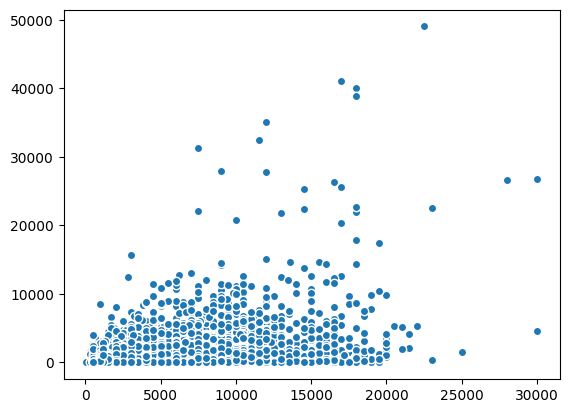

In [112]:
plt.scatter(df["CREDIT_LIMIT"], df["PURCHASES"], edgecolors="white")

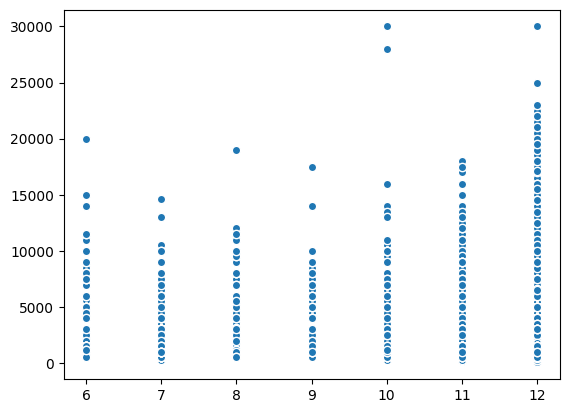

In [113]:
plt.scatter(df["TENURE"], df["CREDIT_LIMIT"], edgecolors="white")

#### **Nhận xét:**


In [114]:
columns=['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
         'CASH_ADVANCE', 'CREDIT_LIMIT',
        'PAYMENTS', 'MINIMUM_PAYMENTS']

for c in columns:
    df_table = df[c].copy()
    Q1 = df_table.quantile(0.25)
    Q3 = df_table.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q1 + 1.5*IQR

    outliers_number = (( df_table < (lower_bound)) | (df_table > (upper_bound))).sum()
    outliers_number

    print("\n" + c)
    print("lower_bound is " + str(lower_bound))
    print("upper_bound is " + str(upper_bound))
    print("Q1 is : " + str(Q1))
    print("Q3 is : " + str(Q3))

    percentage = round((100*outliers_number) / (len(df_table)),2)
    print(str(outliers_number) + " of " + str(len(df_table)) + " is outlier (%" + str(percentage) + ")")


BALANCE
lower_bound is -2760.5052645
upper_bound is 3017.0690955000005
Q1 is : 128.2819155
Q3 is : 2054.1400355
1434 of 8950 is outlier (%16.02)

PURCHASES
lower_bound is -1566.1075000000003
upper_bound is 1645.3775000000003
Q1 is : 39.635
Q3 is : 1110.13
1539 of 8950 is outlier (%17.2)

ONEOFF_PURCHASES
lower_bound is -866.1075
upper_bound is 866.1075
Q1 is : 0.0
Q3 is : 577.405
1703 of 8950 is outlier (%19.03)

INSTALLMENTS_PURCHASES
lower_bound is -702.95625
upper_bound is 702.95625
Q1 is : 0.0
Q3 is : 468.6375
1561 of 8950 is outlier (%17.44)

CASH_ADVANCE
lower_bound is -1670.7317088750003
upper_bound is 1670.7317088750003
Q1 is : 0.0
Q3 is : 1113.8211392500002
1717 of 8950 is outlier (%19.18)

CREDIT_LIMIT
lower_bound is -5750.0
upper_bound is 8950.0
Q1 is : 1600.0
Q3 is : 6500.0
1129 of 8950 is outlier (%12.61)

PAYMENTS
lower_bound is -1893.5110601250003
upper_bound is 2660.0633921250005
Q1 is : 383.276166
Q3 is : 1901.1343167500002
1512 of 8950 is outlier (%16.89)

MINIMUM_PA

> ## **Tiền xử lý dữ liệu**

In [115]:
# Drop column CUST_ID
data = df.iloc[:,1:]
data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [116]:
#
data.loc[(data['MINIMUM_PAYMENTS'].isnull()==True),'MINIMUM_PAYMENTS']=data['MINIMUM_PAYMENTS'].mean()
data.loc[(data['CREDIT_LIMIT'].isnull()==True),'CREDIT_LIMIT']=data['CREDIT_LIMIT'].mean()

### Tạo phạm vi để phân khu giá trị. Bằng cách này, có thể giảm tác động lên tập dữ liệu mà không phải xóa các outliers

In [117]:
columns=['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
        'PAYMENTS', 'MINIMUM_PAYMENTS']

for c in columns:

    Range=c+'_RANGE'
    data[Range]=0
    data.loc[((data[c]>0)&(data[c]<=500)),Range]=1
    data.loc[((data[c]>500)&(data[c]<=1000)),Range]=2
    data.loc[((data[c]>1000)&(data[c]<=3000)),Range]=3
    data.loc[((data[c]>3000)&(data[c]<=5000)),Range]=4
    data.loc[((data[c]>5000)&(data[c]<=10000)),Range]=5
    data.loc[((data[c]>10000)),Range]=6

In [118]:
columns=['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
         'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT']

for c in columns:

    Range=c+'_RANGE'
    data[Range]=0
    data.loc[((data[c]>0)&(data[c]<=0.1)),Range]=1
    data.loc[((df[c]>0.1)&(data[c]<=0.2)),Range]=2
    data.loc[((df[c]>0.2)&(data[c]<=0.3)),Range]=3
    data.loc[((df[c]>0.3)&(data[c]<=0.4)),Range]=4
    data.loc[((df[c]>0.4)&(data[c]<=0.5)),Range]=5
    data.loc[((df[c]>0.5)&(data[c]<=0.6)),Range]=6
    data.loc[((df[c]>0.6)&(data[c]<=0.7)),Range]=7
    data.loc[((df[c]>0.7)&(data[c]<=0.8)),Range]=8
    data.loc[((df[c]>0.8)&(data[c]<=0.9)),Range]=9
    data.loc[((df[c]>0.9)&(data[c]<=1.0)),Range]=10

In [119]:
columns=['PURCHASES_TRX', 'CASH_ADVANCE_TRX']

for c in columns:

    Range=c+'_RANGE'
    data[Range]=0
    data.loc[((data[c]>0)&(data[c]<=5)),Range]=1
    data.loc[((data[c]>5)&(data[c]<=10)),Range]=2
    data.loc[((data[c]>10)&(data[c]<=15)),Range]=3
    data.loc[((data[c]>15)&(data[c]<=20)),Range]=4
    data.loc[((data[c]>20)&(data[c]<=30)),Range]=5
    data.loc[((data[c]>30)&(data[c]<=50)),Range]=6
    data.loc[((data[c]>50)&(data[c]<=100)),Range]=7
    data.loc[((data[c]>100)),Range]=8

In [120]:
data.drop(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY',  'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT' ], axis=1, inplace=True)

X= np.asarray(data)

### Normalizing Inputs

In [121]:
scale = StandardScaler()
original_X = scale.fit_transform(X)
original_X.shape

(8950, 17)

> ## **Xây dựng mô hình**

### Chọn số lượng cụm: Sử dụng phương pháp Elbow

#### Sơ lược về phương pháp Elbow:

Là một phương pháp được sử dụng để chọn số lượng cụm tối ưu trong thuật toán KMeans dựa trên sự thay đổi trong phương sai giữa các cụm.

Cụ thể, phương pháp là:
+ **Trực quan hóa kết quả lên biểu đồ:** Trực quan hóa kết quả bằng cách vẽ biểu đồ của phương sai theo số lượng cụm. Phương sai thường giảm khi số lượng cụm tăng vì càng nhiều cụm thì sự tập trung của các điểm dữ liệu vào các cụm sẽ tăng lên.

+ **Chọn số lượng cụm tối ưu:** Xác định điểm "elbow" trên biểu đồ, nơi mà sự giảm đáng kể của phương sai bắt đầu giảm dần. Điểm này thường được xem là số lượng cụm tối ưu. Cụ thể, nếu trên biểu đồ có một điểm tương đối rõ ràng nơi phương sai bắt đầu giảm chậm hơn so với các giá trị trước đó, thì đó có thể được coi là điểm "elbow".

In [122]:
n_clusters=15
cost=[]
for i in range(1,n_clusters):
    kmean= KMeans(i)
    kmean.fit(original_X)
    cost.append(kmean.inertia_)

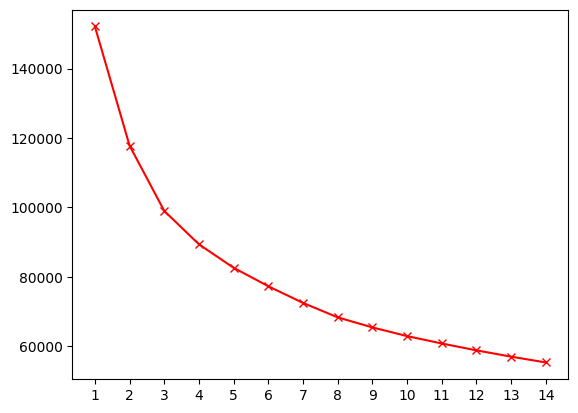

In [123]:
plt.plot(range(1,15),cost, 'rx-')
plt.xticks([i for i in range(1,15)])
plt.show()

Ta thấy điểm elbow tại 3, 4 hoặc 5. Chúng ta sẽ sử dụng độ đo  Silhouette Coefficient để xác định số cụm tốt hơn.

### Chọn số lượng cụm: Sử dụng độ đo Silhouette

Độ đo Silhouette coefficient (SC) cho biết mức độ phù hợp của mỗi điểm dữ liệu với cụm mà nó được phân chia. Giá trị SC càng cao, nghĩa là điểm dữ liệu càng phù hợp với cụm của nó.



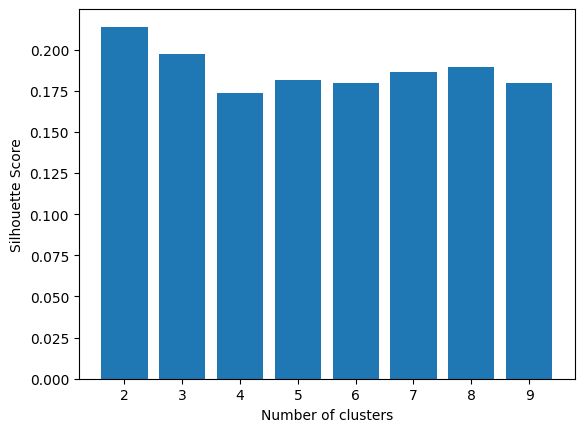

In [124]:
silhouette_scores = []

for n_cluster in range(2, 10):
    silhouette_scores.append(
        silhouette_score(original_X, KMeans(n_clusters = n_cluster).fit_predict(original_X)))

# Plotting a bar graph to compare the results
k = [i for i in range(2,10)]
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 10)
plt.ylabel('Silhouette Score', fontsize = 10)
plt.show()

Ta thấy số cụm có điểm số Silhouette cao nhất lần lượt là 2 và 3, thấp nhất tại 4. Do đó ta có thể thử số cụm là 2 hoặc 3.
> Ta sẽ đánh giá độ hiệu quả của việc phân cụm với 2 và 3 cụm ở phần cuối.

### Sinh thêm dữ liệu đầu vào

In [125]:
num_new_samples = 91050

new_data = np.empty((num_new_samples, original_X.shape[1]))
for col_idx in range(original_X.shape[1]):
  new_data[:,col_idx] = np.random.choice(original_X[:, col_idx], size=num_new_samples, replace=True)

X = np.concatenate((original_X, new_data), axis=0)

X.shape

(100000, 17)

In [126]:
np.savetxt('X.gz', X, fmt='%f')

### Phiên bản Sckit-Learn: Dùng phương pháp KMeans của thư viện sklearn.cluster

#### Thiết kế

Ở phiên bản này chúng ta sử dụng thư viện nên có thể bỏ qua bước thiết kế.
> Để có thể dễ dàng so sánh kết quả với các phiên bản sau, ta sẽ sử dụng các trung tâm ban đầu giống nhau là 6 điểm dữ liệu đầu tiên.

#### Cài đặt:

In [127]:
k = 20
kmean= KMeans(n_clusters=k, tol=0, init=X[:k])

start = time.time()
kmean.fit(X)
end = time.time()

correct_labels = kmean.labels_

#### Đánh giá

**To do**

##### Thời gian chạy

In [128]:
kmean.n_iter_

135

In [129]:
km_time = end - start
all_results.loc['use library', 'time (s)'] = km_time
all_results

,time (s)
use library,1.134443


Với việc sử dụng Kmeans của thư viện sklearn, thuật toán thực thi rất nhanh chóng.

##### Tính đúng đắn

Vì sử dụng K-Means của thư viện `sklearn`, nên khả năng sai là rất thấp.

### Phiên bản tuần tự: Cài đặt hàm KMeans truyền thống

#### Thiết kế

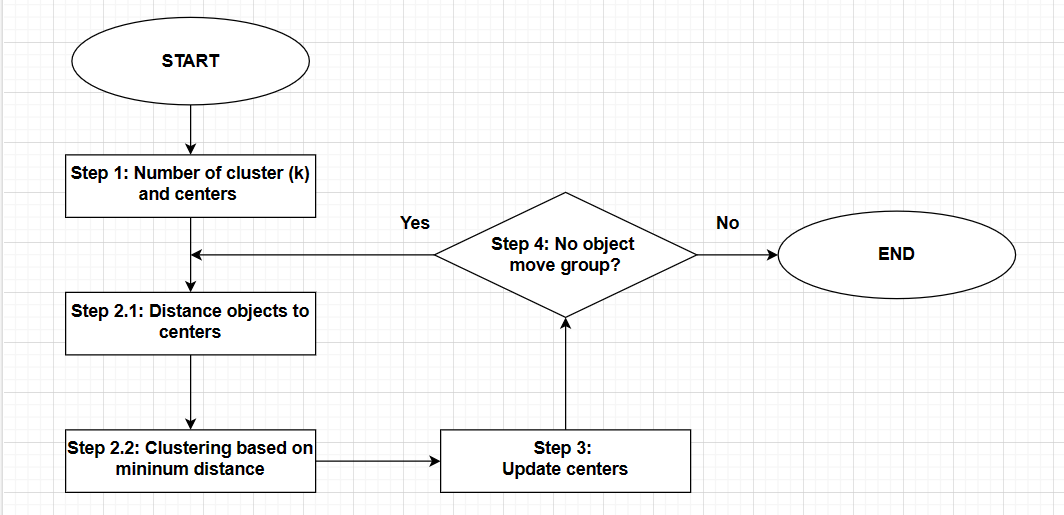

Dựa trên sơ đồ khối trên ta sẽ xây dựng ```class K_Means``` gồm các hàm sau:
+ `def init_center(self, X)`: thực hiện khởi tạo các trung tâm đầu tiên, ở bài này ta sẽ chọn k điểm đầu tiên dữ liệu.
+ `def assign_labels(self, X)`: phân cụm cho tất cả điểm dữ liệu. Trong đó gọi hàm:
  + `def choose_label(self, x)`: với mỗi điểm dữ liệu tính khoảng cách từ nó đến các trung tâm và xác định cụm gần nhất. Với hàm tính khoảng cách:
    + `def cal_distance(self, x, c)`: tính khoảng Euclid giữa một điểm dữ liệu và trung tâm.
+ `def cal_new_center(self)`: xác định các trung tâm mới sau khi các điểm dự liệu được phân lại cum.
+ `def fit(self, X)`: thực hiện vòng lặp gọi các hàm ở trên đến khi không có sự thay đổi các trung tâm.


#### Cài đặt

In [130]:
class K_Means:
  # init parameter of class
  def __init__(self, k):
    self.k = k
    self.centers = []
    self.labels = []
    self.num_loop = 0

  # chooose random k of center from X
  def init_center(self, X):
    # return X[np.random.choice(X.shape[0], self.k, replace=False)]
    return X[:self.k]

  # assign label for each point
  def assign_labels(self, X):
    return [self.choose_label(x) for x in X]

  # label of point
  def choose_label(self, x):
    return np.argmin([self.cal_distance(x, c) for c in self.centers])

  #  calculate distance between point and center
  def cal_distance(self, x, c):
    return ((x - c)**2).sum()

  # calculate new center
  def cal_new_center(self, X):
    indices=[]
    for i in range(self.k):
        cluster=[]
        for idx, l in enumerate(self.labels):
            if l==i: cluster.append(idx)
        indices.append(cluster)
    cluster_X = [X[i] for i in indices]

    # calculate the new centers
    new_centers = np.asarray([c.sum(axis=0)/len(c) for c in cluster_X])
    # new_centers = [c.sum(axis=0)/len(c) for c in cluster_X]
    # new_centers = [arr.tolist() for arr in new_centers]
    return new_centers

  def fit(self, X):
    self.centers = self.init_center(X);

    self.assign_time = self.cal_ncenter_time = self.check_time = 0
    while(1):
      self.num_loop += 1
      start_assign = time.time()
      self.labels = self.assign_labels(X)

      start_cal_ncenter = time.time()
      new_centers = self.cal_new_center(X)

      start_check = time.time()
      if np.all(new_centers == self.centers):
        break
      else:
        self.centers = new_centers

      end_loop = time.time()

      self.assign_time += (start_cal_ncenter - start_assign)
      self.cal_ncenter_time += (start_check - start_cal_ncenter)
      self.check_time += (end_loop - start_check)
    return self

In [131]:
km = K_Means(k = 20)
res = km.fit(X)

#### Đánh giá

##### Thời gian chạy

In [132]:
total_time = res.assign_time + res.cal_ncenter_time + res.check_time
print("Thời gian phân cụm: ", res.assign_time)
print("Thời gian tính các trung tâm mới: ", res.cal_ncenter_time)
print("Thời gian kiểm tra sự thay đổi các trung tâm: ", res.check_time)
print("Tổng thời gian: ", total_time)
all_results.loc['sequential', 'time (s)'] = total_time
all_results

Thời gian phân cụm:  1459.6883494853973
Thời gian tính các trung tâm mới:  30.20432186126709
Thời gian kiểm tra sự thay đổi các trung tâm:  0.00745391845703125
Tổng thời gian:  1489.9001252651215


,time (s)
use library,1.134443
sequential,1489.900125


Phiên bản tuần tự của K-Means chạy chậm hơn rất nhiều so với thư viện sklearn.
> Ta thấy phiên bản tuần tự tốn chủ yếu thời gian cho việc phân cụm các điểm dữ liệu sau khi các trung tâm mới được tính. Ta có thể thực hiện song song hóa phần này để tăng hiệu suất.

##### Tính đúng đắn

Để kiểm tra tính đúng đắn, ta sẽ so sánh kết quả gán nhãn của phiên bản tuần tự và phiên bản sử dụng thư viện:

In [133]:
np.sum(res.labels == correct_labels)

100000

Kết quả gán nhãn cho các điểm dữ liệu ở hai phiên bản tuần tự và sử dụng thư viện là giống nhau cho tất các điểm dữ liệu.
> Vậy có thể kết luận thuật toán tuần tự K-Means ở trên là đúng.

### Phiên bản song song cơ bản 1

#### Phân tích

Như đã thấy ở phiên bản tuần tự thì thời gian chủ yếu của thuật toán Kmeans là cho việc phân cụm dữ liệu. Cho nên ở phiên bản đầu tiên chúng ta sẽ tập trung song song cho việc phân cụm dữ liệu.

#### Thiết kế

Ta sẽ viết lại hàm `assign_label` với hàm này chính là kernel.
- Input: X(các điểm dữ liệu đầu vào), centers(các trung tâm), k(số cụm), dis_arr(ma trận khoảng cách với mỗi dòng là 1 điểm dữ liệu và các trung tâm)
- Các bước thực hiện:
  +  Thực hiện cấp phát bộ nhớ cho `dis_arr`
  + Gọi hàm kernel `assign_labels1[grid_size, block_size](X, self.centers, self.labels, self.k, dis_arr)`:
    - Sử dụng block 1D với mỗi thread thực hiện xác định label cho 1 điểm  dữ liệu.
    - Mỗi thread sẽ thực hiện tính khoảng cách từ một điểm dữ liệu đến các trung tâm.
    - Sau đó mỗi thread sẽ thực hiện tìm index của khoảng cách nhỏ nhất có trong mảng `dis_arr[r,:]` để xác định label cho điểm dữ liệu được tính.
- Output: mảng `labels` xác định nhãn cho các điểm dữ liệu.

#### Cài đặt

In [134]:
# assign label for each point
@cuda.jit
def assign_labels1(X, centers, labels, k, dis_arr):
  index = cuda.grid(1)
  dim = X.shape[1]

  if index < X.shape[0]:
    for idx_k in prange(k):
      dis = 0
      for i in range(dim):
        dis += (X[index, i] - centers[idx_k, i])**2
      dis_arr[index][idx_k] = dis

    idx_min = 0
    for i in range(1, k):
      if dis_arr[index, i] < dis_arr[index, idx_min]:
        idx_min = i

    labels[index] = idx_min

In [135]:
class K_Means_P:
  # init parameter of class
  def __init__(self, k):
    self.k = k
    self.num_loop = 0

  # chooose random k of center from X
  def init_center(self, X):
    return X[:self.k]


  def cal_new_center(self, X):
    indices=[]
    new_labels = self.labels.tolist()
    for i in range(self.k):
        cluster=[]
        for idx, l in enumerate(new_labels):
            if l==i: cluster.append(idx)
        indices.append(cluster)
    cluster_X = [X[i] for i in indices]

    # calculate the new centers
    new_centers = np.asarray([c.sum(axis=0)/len(c) for c in cluster_X])

    return new_centers

  def fit(self, X):
    # khởi tạo các mảng numpy cần thiết
    start_init = time.time()
    X = np.ascontiguousarray(X)
    self.centers = self.init_center(X);
    self.labels = np.zeros(len(X), dtype=int)
    dis_arr = np.zeros((X.shape[0], k), dtype=float)

    block_size = (32,)
    grid_size = (math.ceil(len(X) / block_size[0]),)

    # Khởi tạo các mốc thời gian
    self.assign_time = self.cal_ncenter_time = self.check_time = 0
    end_init = time.time()
    self.init_time = end_init - start_init

    while(1):
      self.num_loop += 1
      start_assign = time.time()

      # call kernel
      assign_labels1[grid_size, block_size](X, self.centers, self.labels, self.k, dis_arr)
      cuda.synchronize()

      start_cal_ncenter = time.time()
      new_centers = self.cal_new_center(X)

      start_check = time.time()
      if np.all(new_centers == self.centers):
        break
      else:
        self.centers = new_centers

      end_loop = time.time()

      self.assign_time += (start_cal_ncenter - start_assign)
      self.cal_ncenter_time += (start_check - start_cal_ncenter)
      self.check_time += (end_loop - start_check)
    return self

In [136]:
# small data to compile
x_test = np.random.rand(10,2)
km_test= K_Means_P(k=10)
res_test = km_test.fit(x_test)

In [137]:
km = K_Means_P(k = 20)
res_p = km.fit(X)

#### Đánh giá

##### Thời gian chạy

In [138]:
total_time = res_p.assign_time + res_p.cal_ncenter_time + res_p.check_time + res_p.init_time
print("Thời gian khởi tạo: ", res_p.init_time)
print("Thời gian phân cụm: ", res_p.assign_time)
print("Thời gian tính các trung tâm mới: ", res_p.cal_ncenter_time)
print("Thời gian kiểm tra sự thay đổi các trung tâm: ", res_p.check_time)
print("Tổng thời gian: ", total_time)

all_results.loc['parallel basic', 'time (s)'] = total_time
all_results

Thời gian khởi tạo:  0.0001659393310546875
Thời gian phân cụm:  2.690837860107422
Thời gian tính các trung tâm mới:  20.999285459518433
Thời gian kiểm tra sự thay đổi các trung tâm:  0.00691986083984375
Tổng thời gian:  23.697209119796753


,time (s)
use library,1.134443
sequential,1489.900125
parallel basic,23.697209


**Nhận xét:**
- Thời gian thực thi của phiên bản song song cơ bản 1 đã giảm rất nhiều so với phiên bản tuần tự. Tuy nhiên vẫn chậm hơn sử dụng thư viện khoảng 20 lần.
- Ta nhận thấy lúc này thời gian cho nhiệm vụ tính lại trung tâm mới chiếm phần lớn thời gian chạy thuật toán.

##### Tính đúng đắn

Để kiểm tra tính đúng đắn, ta sẽ so sánh kết quả gán nhãn của phiên bản này và phiên bản sử dụng thư viện:

In [139]:
np.sum(res_p.labels == correct_labels)

100000

Kết quả gán nhãn cho các điểm dữ liệu ở hai phiên bản song song cơ bản 1 và sử dụng thư viện là giống nhau cho tất các điểm dữ liệu.
> Vậy có thể kết luận thuật toán song song cơ bản 1 cho K-Means ở trên là đúng.

### Phiên bản song song cơ bản 1 + Tối ưu tính trung tâm trên CPU

#### Phân tích

Qua phiên bản song song cơ bản 1, ta thấy lúc này thời gian thực thi cho nhiệm vụ tính các trung tâm mới chiếm nhiều thời gian nhất trong các bước. Ta sẽ thực hiện tối ưu phần này.

---

Trong các phiên bản trên, việc tính lại các các trung tâm mới bao gồm bước xác định index của các điểm dữ liệu trong từng cụm như sau:
```
    for i in range(self.k):
        cluster=[]
        for idx, l in enumerate(new_labels):
            if l==i: cluster.append(idx)
```
Đoạn code này sẽ thực hiện duyệt qua từng cụm và ở mỗi cụm sẽ duyệt qua từng label của các điểm dữ liệu, nếu nó thuộc vào cụm thì index của nó sẽ được thêm vào mảng `cluster`.

Ta thấy ở đây ta chỉ có thể song song phần duyệt qua từng cụm vì nó độc lập với nhau. Tuy nhiên số lượng cụm thường sẽ không quá lớn và kích thước `cluster` là chưa xác định được trước để cấp phát.
-> Do đó ta sẽ không song song hàm tính lại các trung tâm mới mà sẽ viết một hàm mới tuần tự nhưng có thể tăng tốc cho phần này.

#### Thiết kế

- Chuyển mảng `labels` thành ma trận one-hot với kích thước (n, k). Mỗi dòng sẽ thể hiện label cho một điểm dữ liệu.
- Nhân hai ma trận `labels.T`(k, n)  và `X`(n, dim). Ta được ma trận kết quả có kích thước (k, dim) với mỗi dòng là tổng của các điểm dữ liệu thuộc cùng một cụm.
- Chia ma trận trên cho số điểm dữ liệu thuộc mỗi cụm, ta được kết quả là các trung tâm mới.

#### Cài đặt

In [140]:
class K_Means_PCPU:
  # init parameter of class
  def __init__(self, k):
    self.k = k
    self.num_loop = 0

  # chooose random k of center from X
  def init_center(self, X):
    return X[:self.k]

  def cal_new_center(self, X):
    # Tạo ma trận nhãn one-hot
    one_hot_labels = np.eye(self.k)[self.labels]

    # Tính toán tổng theo cụm
    cluster_sums = np.dot(one_hot_labels.T, X)

    # Đếm số điểm trong mỗi cụm
    cluster_counts = np.sum(one_hot_labels, axis=0)

    # Tránh chia cho 0
    cluster_counts[cluster_counts == 0] = 1

    # Tính trung tâm mới của các cụm
    new_centers = cluster_sums / cluster_counts[:, None]

    return new_centers

  def fit(self, X):
    # khởi tạo các mảng numpy cần thiết
    start_init = time.time()
    X = np.ascontiguousarray(X)
    self.centers = self.init_center(X);
    self.labels = np.zeros(len(X), dtype=int)
    dis_arr = np.zeros((X.shape[0], k), dtype=float)

    block_size = (32,)
    grid_size = (math.ceil(len(X) / block_size[0]),)

    # Khởi tạo các mốc thời gian
    self.assign_time = self.cal_ncenter_time = self.check_time = 0
    end_init = time.time()
    self.init_time = end_init - start_init

    while(1):
    # for i in range(2):
      self.num_loop += 1
      start_assign = time.time()

      # call kernel
      assign_labels1[grid_size, block_size](X, self.centers, self.labels, self.k, dis_arr)
      cuda.synchronize()

      start_cal_ncenter = time.time()
      new_centers = self.cal_new_center(X)

      start_check = time.time()
      if np.all(new_centers == self.centers):
        break
        # print("ok")
      else:
        self.centers = new_centers

      end_loop = time.time()

      self.assign_time += (start_cal_ncenter - start_assign)
      self.cal_ncenter_time += (start_check - start_cal_ncenter)
      self.check_time += (end_loop - start_check)
    return self

In [141]:
# small data to compile
x_test = np.random.rand(10,2)
km_test= K_Means_PCPU(k=10)
res_test = km_test.fit(x_test)

In [142]:
km = K_Means_PCPU(k = 20)
res_pcpu = km.fit(X)

#### Đánh giá

##### Thời gian chạy

In [143]:
total_time = res_pcpu.assign_time + res_pcpu.cal_ncenter_time + res_pcpu.check_time + res_pcpu.init_time
print("Thời gian khởi tạo: ", res_pcpu.init_time)
print("Thời gian phân cụm: ", res_pcpu.assign_time)
print("Thời gian tính các trung tâm mới: ", res_pcpu.cal_ncenter_time)
print("Thời gian kiểm tra sự thay đổi các trung tâm: ", res_pcpu.check_time)
print("Tổng thời gian: ", total_time)

all_results.loc['parallel basic + opt cal center', 'time (s)'] = total_time
all_results

Thời gian khởi tạo:  0.0019881725311279297
Thời gian phân cụm:  2.7913122177124023
Thời gian tính các trung tâm mới:  2.032984733581543
Thời gian kiểm tra sự thay đổi các trung tâm:  0.005111217498779297
Tổng thời gian:  4.8313963413238525


,time (s)
use library,1.134443
sequential,1489.900125
parallel basic,23.697209
parallel basic + opt cal center,4.831396


**Nhận xét:**
- Thời gian thực thi của phiên bản trên đã giảm khoảng 4 lần so với phiên bản song song cơ bản 1. Tuy nhiên vẫn chậm hơn phiên bản sử dụng thư viện.
- Lúc này việc phân cụm lại chiếm nhiều thời gian nhất của thuật toán.

##### Tính đúng đắn

Để kiểm tra tính đúng đắn, ta sẽ so sánh kết quả gán nhãn của phiên bản này và phiên bản sử dụng thư viện:

In [144]:
np.sum(res_pcpu.labels == correct_labels)

100000

Kết quả gán nhãn cho các điểm dữ liệu ở hai phiên bản song song cở bản 1 kết hợp tối ưu tính toán trung tâm cụm và sử dụng thư viện là giống nhau cho tất các điểm dữ liệu.
> Vậy có thể kết luận phiên bản K-Means ở trên là đúng.

### Phiên bản song song cơ bản 2: Mỗi thread xử lý cho một chiều của dữ liệu

#### Phân tích

Ở phiên bản song song cơ bản 1 ta đang sử dụng 1 thread để tính toán cho một điểm dữ liệu. Do đó khi một điểm dữ liệu có số chiều lớn thì thread sẽ phải thực hiện nhiều phép toán.

-> Ta có thể sử dụng block 2D với chiều x đại diện cho số chiều của một điểm dữ liệu và y đại diện cho số điểm dữ liệu để giảm khối lượng tính toán cho mỗi thread.

#### Thiết kế

Tương tự với phiên bản song song cơ bản 1 ta sẽ viết lại hàm `assign_label` với hàm này chính là kernel.
- Input: X(các điểm dữ liệu đầu vào), centers(các trung tâm), k(số cụm), dis_arr(ma trận khoảng cách với mỗi dòng là 1 điểm dữ liệu tới các trung tâm)
- Các bước thực hiện:
  +  Thực hiện cấp phát bộ nhớ cho `dis_arr`
  + Gọi hàm kernel `assign_labels2[grid_size, block_size](X, self.centers, self.labels, self.k, dis_arr)`:
    - Sử dụng block 2D với mỗi thread thực hiện `k` vòng lặp tính khoảng cách `dis` cho 1 chiều của điểm dữ liệu đến chiều tương ứng của trung tâm thứ `idx_k`. Sau đó thực hiện cộng `dis` vào biến `dis_arr[r, idx_k]` với `r` là dòng thread thuộc vào.
    - Sau khi tất cả thread đã thực hiện tính khoảng cách đến các trung tâm. Một thread sẽ được chọn để xác định index của phần tử nhỏ nhất có trong mảng `dis_arr[r,:]` để xác định label cho điểm dữ liệu được tính.
- Output: mảng `labels` xác định nhãn cho các điểm dữ liệu.

#### Cài đặt

In [145]:
# assign label for each point
@cuda.jit
def assign_labels2(X, centers, labels, k, dis_arr):
  # r = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
  # c = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
  c, r = cuda.grid(2)

  if c < X.shape[1] and r < X.shape[0]:
    for idx_k in prange(k):
      dis = (X[r, c] - centers[idx_k, c])**2
      cuda.atomic.add(dis_arr, (r, idx_k), dis)

    cuda.syncthreads()
    if c == 0:
      idx_min = 0
      for i in range(1, k):
        if dis_arr[r, i] < dis_arr[r, idx_min]:
          idx_min = i

      labels[r] = idx_min

In [146]:
class K_Means_P2:
  # init parameter of class
  def __init__(self, k):
    self.k = k
    self.num_loop = 0

  # chooose random k of center from X
  def init_center(self, X):
    return X[:self.k]

  def cal_new_center(self, X):
    # Tạo ma trận nhãn one-hot
    one_hot_labels = np.eye(self.k)[self.labels]
    # Tính toán tổng theo cụm
    cluster_sums = np.dot(one_hot_labels.T, X)
    # Đếm số điểm trong mỗi cụm
    cluster_counts = np.sum(one_hot_labels, axis=0)
    # Tránh chia cho 0
    cluster_counts[cluster_counts == 0] = 1
    # Tính trung tâm mới của các cụm
    new_centers = cluster_sums / cluster_counts[:, None]

    return new_centers

  def fit(self, X):
    # khởi tạo các mảng numpy cần thiết
    start_init = time.time()
    X = np.ascontiguousarray(X)
    self.centers = self.init_center(X);
    self.labels = np.zeros(len(X), dtype=int)
    # dis_arr = np.zeros((X.shape[0], k), dtype=float)

    block_size = (32,32)
    grid_size = (math.ceil(X.shape[1] / block_size[0]), math.ceil(X.shape[0] / block_size[1]) )
    # Khởi tạo các mốc thời gian
    self.assign_time = self.cal_ncenter_time = self.check_time = 0
    end_init = time.time()
    self.init_time = end_init - start_init

    while(1):
    # for i in range(2):
      self.num_loop += 1
      start_assign = time.time()

      dis_arr = np.zeros((X.shape[0], self.k), dtype=float)
      # call kernel
      assign_labels2[grid_size, block_size](X, self.centers, self.labels, self.k, dis_arr)
      # self.labels = np.argmin(dis_arr, axis=1)
      cuda.synchronize()

      # Tính lại trung tâm
      start_cal_ncenter = time.time()
      new_centers = self.cal_new_center(X)

      # so sánh centers mới và center cũ
      start_check = time.time()
      if np.all(new_centers == self.centers):
        break
        # print("ok")
      else:
        self.centers = new_centers

      end_loop = time.time()

      self.assign_time += (start_cal_ncenter - start_assign)
      self.cal_ncenter_time += (start_check - start_cal_ncenter)
      self.check_time += (end_loop - start_check)
    return self

In [147]:
# small data to compile
x_test = np.random.rand(10,2)
km_test= K_Means_P2(k=10)
res_test = km_test.fit(x_test)

In [148]:
km = K_Means_P2(k = 20)
res_p2 = km.fit(X)

#### Đánh giá

##### Thời gian chạy

In [149]:
total_time = res_p2.assign_time + res_p2.cal_ncenter_time + res_p2.check_time + res_p2.init_time
print("Thời gian khởi tạo: ", res_p2.init_time)
print("Thời gian phân cụm: ", res_p2.assign_time)
print("Thời gian tính các trung tâm mới: ", res_p2.cal_ncenter_time)
print("Thời gian kiểm tra sự thay đổi các trung tâm: ", res_p2.check_time)
print("Tổng thời gian: ", total_time)

all_results.loc['parallel basic 2', 'time (s)'] = total_time
all_results

Thời gian khởi tạo:  0.00010442733764648438
Thời gian phân cụm:  4.237253665924072
Thời gian tính các trung tâm mới:  2.825817108154297
Thời gian kiểm tra sự thay đổi các trung tâm:  0.004907369613647461
Tổng thời gian:  7.068082571029663


,time (s)
use library,1.134443
sequential,1489.900125
parallel basic,23.697209
parallel basic + opt cal center,4.831396
parallel basic 2,7.068083


**Nhận xét:**
- So với phiên bản trước thời gian thực thi của phiên bản này đã chậm hơn.
- Nguyên nhân có thể là vì hàm `cuda.atomic.add()` và `cuda.syncthreads()` đã làm cho các thread phải đợi nhau thực hiện xong.

##### Tính đúng đắn

Để kiểm tra tính đúng đắn, ta sẽ so sánh kết quả gán nhãn của phiên bản này và phiên bản sử dụng thư viện:

In [150]:
np.sum(res_p2.labels == correct_labels)

100000

Kết quả gán nhãn cho các điểm dữ liệu ở hai phiên bản song song cơ bản 2 và sử dụng thư viện là giống nhau cho tất các điểm dữ liệu.
> Vậy có thể kết luận phiên bản K-Means ở trên là đúng.

### Phiên bản tối ưu 1: Tối ưu lại quá trình chuyển đổi

#### Phân tích

In [151]:
%%writefile parallel2.py
import time
import numpy as np
import math
from numba import cuda, prange, jit
import numba

# assign label for each point
@cuda.jit
def assign_labels2(X, centers, labels, k, dis_arr):
  # r = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
  # c = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
  c, r = cuda.grid(2)

  if c < X.shape[1] and r < X.shape[0]:
    for idx_k in prange(k):
      dis = (X[r, c] - centers[idx_k, c])**2
      cuda.atomic.add(dis_arr, (r, idx_k), dis)

    cuda.syncthreads()
    if c == 0:
      idx_min = 0
      for i in range(1, k):
        if dis_arr[r, i] < dis_arr[r, idx_min]:
          idx_min = i

      labels[r] = idx_min

class K_Means_P2:
  # init parameter of class
  def __init__(self, k):
    self.k = k
    self.num_loop = 0

  # chooose random k of center from X
  def init_center(self, X):
    return X[:self.k]

  def cal_new_center(self, X):
    # Tạo ma trận nhãn one-hot
    one_hot_labels = np.eye(self.k)[self.labels]
    # Tính toán tổng theo cụm
    cluster_sums = np.dot(one_hot_labels.T, X)
    # Đếm số điểm trong mỗi cụm
    cluster_counts = np.sum(one_hot_labels, axis=0)
    # Tránh chia cho 0
    cluster_counts[cluster_counts == 0] = 1
    # Tính trung tâm mới của các cụm
    new_centers = cluster_sums / cluster_counts[:, None]

    return new_centers

  def fit(self, X):
    # khởi tạo các mảng numpy cần thiết
    start_init = time.time()
    X = np.ascontiguousarray(X)
    self.centers = self.init_center(X);
    self.labels = np.zeros(len(X), dtype=int)
    # dis_arr = np.zeros((X.shape[0], k), dtype=float)

    block_size = (32,32)
    grid_size = (math.ceil(X.shape[1] / block_size[0]), math.ceil(X.shape[0] / block_size[1]) )
    # Khởi tạo các mốc thời gian
    self.assign_time = self.cal_ncenter_time = self.check_time = 0
    end_init = time.time()
    self.init_time = end_init - start_init

    while(1):
    # for i in range(2):
      self.num_loop += 1
      start_assign = time.time()

      dis_arr = np.zeros((X.shape[0], self.k), dtype=float)
      # call kernel
      assign_labels2[grid_size, block_size](X, self.centers, self.labels, self.k, dis_arr)
      # self.labels = np.argmin(dis_arr, axis=1)
      cuda.synchronize()

      # Tính lại trung tâm
      start_cal_ncenter = time.time()
      new_centers = self.cal_new_center(X)

      # so sánh centers mới và center cũ
      start_check = time.time()
      if np.all(new_centers == self.centers):
        break
        # print("ok")
      else:
        self.centers = new_centers

      end_loop = time.time()

      self.assign_time += (start_cal_ncenter - start_assign)
      self.cal_ncenter_time += (start_check - start_cal_ncenter)
      self.check_time += (end_loop - start_check)
    return self, dis_arr

# small data to compile
x_test = np.random.rand(10,2)
km_test= K_Means_P2(k=10)
res_test = km_test.fit(x_test)

X = np.loadtxt('X.gz', dtype=float)
km = K_Means_P2(k = 20)
res_p2, dis_arr = km.fit(X)


Overwriting parallel2.py


In [152]:
!python parallel2.py

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [153]:
!nvprof --print-gpu-trace python parallel2.py

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
==8647== NVPROF is profiling process 8647, command: python3 parallel2.py
/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
==8647== Profiling application: python3 parallel2.py
==8647== Profiling result:
   Start  Duration            Grid Size      Block Size     Regs*    SSMem*    DSMem*      Size  Throughput  SrcMemType  DstMemType           Device   Context    Stream  Name
560.42ms  1.0230us                    -               -         -         -         -      160B  149.16MB/s    Pageable      Device     Tesla T4 (0)         1         7  [CUDA memcpy HtoD]
560.77ms     704ns                    -               -     

Ta tiến hành xem thông tin của phiên bản song song cơ bản trước qua câu lệnh `nvprof`, ta thấy được:

Các mảng `X`, `centers`, `labels`, `dis_arr` luôn được Numba tự động copy từ bộ nhớ của CPU/host sang bộ nhớ của GPU/device. Khi các thread bên GPU/device chạy xong hàm kernel thì Numba lại tự động copy toàn bộ các mảng đó từ GPU/device về bộ nhớ của CPU/host => Việc copy như vậy là dư thừa nên ta có thể tối ưu hóa phần này để tăng tốc.

Từ đó, ta nên tối ưu bằng cách:
+ Copy từ bộ nhớ của CPU/host sang bộ nhớ của GPU/device: `X`, `centers`, `dis_arr`
+ Copy từ bộ nhớ của GPU/device về bộ nhớ của CPU/host: `labels`

#### Thiết kế

Ta sẽ viết lại hàm `fit` để tối ưu lại quá trình chuyển đổi.
- Input: X(các điểm dữ liệu đầu vào), centers(các trung tâm), k(số cụm), dis_arr(array khoảng cách giữa 1 điểm dữ liệu và các trung tâm)

(Lưu ý: Vì cài đặt trong class nên hàm `fit` sẽ có khác biệt)
- Các bước thực hiện:  
  + Copy dữ liệu từ `X`, `centers` và `dis_arr` ở bộ nhớ của CPU/host sang `d_X`, `d_centers` và `d_dis_arr` ở bộ nhớ của GPU/device
  + Cấp phát vùng nhớ ở GPU/device cho `d_labels`
  + Gọi hàm kernel `assign_labels[grid_size, block_size](d_X, d_centers, d_labels, k, d_dis_arr)`(Hàm này được viết tương tự như phiên bản song song cơ bản)
  + Copy kết quả từ `d_labels` ở bộ nhớ của GPU/device về `labels` ở bộ nhớ của CPU/host
- Output: Kết quả cuối cùng: Mảng `labels` xác định nhãn cho các điểm dữ liệu, mảng `centers` xác định trung tâm các cụm

#### Cài đặt

In [154]:
# assign label for each point
@cuda.jit
def assign_labels(X, centers, labels, k, dis_arr):
  index = cuda.grid(1)
  dim = X.shape[1]

  if index < X.shape[0]:
    for idx_k in prange(k):
      dis = 0
      for i in range(dim):
        dis += (X[index, i] - centers[idx_k, i])**2
      dis_arr[index][idx_k] = dis

    idx_min = 0
    for i in range(1, k):
      if dis_arr[index, i] < dis_arr[index, idx_min]:
        idx_min = i

    labels[index] = idx_min


In [155]:
class K_Means_OPT1:
  # init parameter of class
  def __init__(self, k):
    self.k = k
    self.num_loop = 0

  # chooose random k of center from X
  def init_center(self, X):
    return X[:self.k]

  def cal_new_center(self, X):
    # Tạo ma trận nhãn one-hot
    one_hot_labels = np.eye(self.k)[self.labels]

    # Tính toán tổng theo cụm
    cluster_sums = np.dot(one_hot_labels.T, X)

    # Đếm số điểm trong mỗi cụm
    cluster_counts = np.sum(one_hot_labels, axis=0)

    # Tránh chia cho 0
    cluster_counts[cluster_counts == 0] = 1

    # Tính trung tâm mới của các cụm
    new_centers = cluster_sums / cluster_counts[:, None]

    return new_centers

  def fit(self, X):
    # khởi tạo các mảng numpy cần thiết
    start_init = time.time()
    X = np.ascontiguousarray(X)
    self.centers = self.init_center(X);
    # self.labels = np.zeros(len(X), dtype=int)
    # dis_arr = np.zeros((X.shape[0], k), dtype=float)

    block_size = (32,)
    grid_size = (math.ceil(len(X) / block_size[0]),)

    # Khởi tạo các mốc thời gian
    self.assign_time = self.cal_ncenter_time = self.check_time = 0
    end_init = time.time()
    self.init_time = end_init - start_init

    while(1):
    # for i in range(2):
      self.num_loop += 1
      start_assign = time.time()

      # call kernel
      d_X = cuda.to_device(X)
      d_centers = cuda.to_device(self.centers)

      d_dis_arr = cuda.device_array((X.shape[0], k), dtype=float)
      d_labels = cuda.device_array((X.shape[0], ), dtype=int)
      assign_labels[grid_size, block_size](d_X, d_centers, d_labels, k, d_dis_arr)
      cuda.synchronize()
      self.labels = d_labels.copy_to_host()

      start_cal_ncenter = time.time()
      new_centers = self.cal_new_center(X)

      start_check = time.time()
      if np.all(new_centers == self.centers):
        break
        # print("ok")
      else:
        self.centers = new_centers

      end_loop = time.time()

      self.assign_time += (start_cal_ncenter - start_assign)
      self.cal_ncenter_time += (start_check - start_cal_ncenter)
      self.check_time += (end_loop - start_check)
    return self

In [156]:
# small data to compile
x_test = np.random.rand(10,2)
km_test= K_Means_OPT1(k=10)
res_test = km_test.fit(x_test)

In [157]:
km = K_Means_OPT1(k = 20)
res_popt1 = km.fit(X)

#### Đánh giá

##### Thời gian chạy

In [158]:
total_time = res_popt1.assign_time + res_popt1.cal_ncenter_time + res_popt1.check_time + res_popt1.init_time
print("Thời gian khởi tạo: ", res_popt1.init_time)
print("Thời gian phân cụm: ", res_popt1.assign_time)
print("Thời gian tính các trung tâm mới: ", res_popt1.cal_ncenter_time)
print("Thời gian kiểm tra sự thay đổi các trung tâm: ", res_popt1.check_time)
print("Tổng thời gian: ", total_time)

all_results.loc['parallel opt 1: opt convert process', 'time (s)'] = total_time
all_results

Thời gian khởi tạo:  1.1682510375976562e-05
Thời gian phân cụm:  1.3115313053131104
Thời gian tính các trung tâm mới:  2.087606191635132
Thời gian kiểm tra sự thay đổi các trung tâm:  0.005081653594970703
Tổng thời gian:  3.404230833053589


,time (s)
use library,1.134443
sequential,1489.900125
parallel basic,23.697209
parallel basic + opt cal center,4.831396
parallel basic 2,7.068083
parallel opt 1: opt convert process,3.404231


##### Tính đúng đắn

In [159]:
np.sum(res_popt1.labels == correct_labels)

100000

### Phiên bản tối ưu 2: Trong `assign_labels` bỏ centers vào SMEM

#### Phân tích

Ta sẽ tập trung tối ưu hóa hàm kernel `assign_labels` do hàm này chiếm thời gian chạy nhiều nhất. Để ý thấy mảng `centers` trong mỗi lần lặp đều không thay đổi. Vì thế ta tiến hành lưu centers vào SMEM để giảm số lần truy xuất trong GMEM

#### Thiết kế

Ta sẽ viết lại hàm `assign_label_opt1` để thêm `centers` vào SMEM.
- Input: X(các điểm dữ liệu đầu vào), centers(các trung tâm), k(số cụm), dis_arr(array khoảng cách giữa 1 điểm dữ liệu và các trung tâm)

- Các bước thực hiện:
  + Ta thực hiện lưu dữ liệu của `centers` vào `smem_centers` của  bộ nhớ SMEM  
  + Tiếp theo tương tự như hàm `assign_label` của phiên bản song song cơ bản, tuy nhiên khi tính khoảng cách thì ta sử dụng `smem_centers` thay vì `centers`
- Output: Mảng `labels` xác định nhãn cho các điểm dữ liệu

#### Cài đặt

In [160]:
# assign label for each point
@cuda.jit
def assign_labels_opt1(X, centers, labels, k, dis_arr):
    index = cuda.grid(1)
    dim = X.shape[1]
    smem_centers = cuda.shared.array(shape=(32, 32), dtype=centers.dtype)  # Khai báo Shared Memory cho centers

    # Sao chép dữ liệu từ mảng centers vào Shared Memory
    if cuda.threadIdx.x < k:
        for i in range(dim):
            smem_centers[cuda.threadIdx.x, i] = centers[cuda.threadIdx.x, i]

    # if index < k * dim:
    #   row = index // dim
    #   col = index % dim
    #   smem_centers[row, col] = centers[row, col]


    cuda.syncthreads()  # Đảm bảo dữ liệu đã được sao chép vào Shared Memory trước khi sử dụng

    if index < X.shape[0]:
        for idx_k in prange(k):
            dis = 0
            for i in range(dim):
                # Sử dụng dữ liệu từ Shared Memory thay vì truy cập trực tiếp từ bộ nhớ toàn cục
                dis += (X[index, i] - smem_centers[idx_k, i])**2
            dis_arr[index][idx_k] = dis

        idx_min = 0
        for i in range(1, k):
            if dis_arr[index, i] < dis_arr[index, idx_min]:
                idx_min = i

        labels[index] = idx_min

In [161]:
class K_Means_OPT2:
  # init parameter of class
  def __init__(self, k):
    self.k = k
    self.num_loop = 0

  # chooose random k of center from X
  def init_center(self, X):
    return X[:self.k]

  def cal_new_center(self, X):
    # Tạo ma trận nhãn one-hot
    one_hot_labels = np.eye(self.k)[self.labels]

    # Tính toán tổng theo cụm
    cluster_sums = np.dot(one_hot_labels.T, X)

    # Đếm số điểm trong mỗi cụm
    cluster_counts = np.sum(one_hot_labels, axis=0)

    # Tránh chia cho 0
    cluster_counts[cluster_counts == 0] = 1

    # Tính trung tâm mới của các cụm
    new_centers = cluster_sums / cluster_counts[:, None]

    return new_centers

  def fit(self, X):
    # khởi tạo các mảng numpy cần thiết
    start_init = time.time()
    X = np.ascontiguousarray(X)
    self.centers = self.init_center(X);
    self.labels = np.zeros(len(X), dtype=int)
    dis_arr = np.zeros((X.shape[0], k), dtype=float)

    block_size = (32,)
    grid_size = (math.ceil(len(X) / block_size[0]),)

    # Khởi tạo các mốc thời gian
    self.assign_time = self.cal_ncenter_time = self.check_time = 0
    end_init = time.time()
    self.init_time = end_init - start_init

    while(1):
    # for i in range(2):
      self.num_loop += 1
      start_assign = time.time()

      # call kernel
      assign_labels_opt1[grid_size, block_size](X, self.centers, self.labels, self.k, dis_arr)
      cuda.synchronize()

      start_cal_ncenter = time.time()
      new_centers = self.cal_new_center(X)

      start_check = time.time()
      if np.all(new_centers == self.centers):
        break
        # print("ok")
      else:
        self.centers = new_centers

      end_loop = time.time()

      self.assign_time += (start_cal_ncenter - start_assign)
      self.cal_ncenter_time += (start_check - start_cal_ncenter)
      self.check_time += (end_loop - start_check)
    return self

In [162]:
# small data to compile
x_test = np.random.rand(10,2)
km_test= K_Means_OPT2(k=10)
res_test = km_test.fit(x_test)

In [163]:
km = K_Means_OPT2(k = 20)
res_popt2 = km.fit(X)

#### Đánh giá

##### Thời gian chạy

In [164]:
total_time = res_popt2.assign_time + res_popt2.cal_ncenter_time + res_popt2.check_time + res_popt2.init_time
print("Thời gian khởi tạo: ", res_popt2.init_time)
print("Thời gian phân cụm: ", res_popt2.assign_time)
print("Thời gian tính các trung tâm mới: ", res_popt2.cal_ncenter_time)
print("Thời gian kiểm tra sự thay đổi các trung tâm: ", res_popt2.check_time)
print("Tổng thời gian: ", total_time)

all_results.loc['parallel opt 2: SMEM', 'time (s)'] = total_time
all_results

Thời gian khởi tạo:  0.002554178237915039
Thời gian phân cụm:  3.6858937740325928
Thời gian tính các trung tâm mới:  2.7358558177948
Thời gian kiểm tra sự thay đổi các trung tâm:  0.005125522613525391
Tổng thời gian:  6.429429292678833


,time (s)
use library,1.134443
sequential,1489.900125
parallel basic,23.697209
parallel basic + opt cal center,4.831396
parallel basic 2,7.068083
parallel opt 1: opt convert process,3.404231
parallel opt 2: SMEM,6.429429


##### Tính đúng đắn

In [165]:
np.sum(res_popt2.labels == correct_labels)

100000

### Phiên bản tối ưu 3: Trong `assign_labels` bỏ centers vào CMEM

#### Phân tích

Ta sẽ tập trung tối ưu hóa hàm kernel `assign_labels` do hàm này chiếm thời gian chạy nhiều nhất. Để ý thấy mảng `centers` trong mỗi lần lặp đều không thay đổi. Vì thế ta tiến hành lưu centers vào CMEM để giảm số lần truy xuất trong GMEM

#### Thiết kế

Ta sẽ viết lại hàm `assign_label_opt2` để thêm `centers` vào CMEM.
- Input: X(các điểm dữ liệu đầu vào), centers(các trung tâm), k(số cụm), dis_arr(array khoảng cách giữa 1 điểm dữ liệu và các trung tâm)

- Các bước thực hiện:
  + Ta thực hiện lưu dữ liệu của `centers` vào `cmem_centers` của  bộ nhớ CMEM (Vì cú pháp để thực hiện gọi CMEM trong cuda Numba phải gọi trong hàm của device không ở host nên phải viết thêm 1 hàm để hình thành CMEM cho `centers`)
  + Tiếp theo tương tự như hàm `assign_label` của phiên bản song song cơ bản, tuy nhiên khi tính khoảng cách thì ta sử dụng `cmem_centers` thay vì `centers`
- Output: Mảng `labels` xác định nhãn cho các điểm dữ liệu

#### Cài đặt

In [166]:
@cuda.jit
def constant_array(X, centers):
    index = cuda.grid(1)
    dim = X.shape[1]

    # Sao chép dữ liệu từ mảng centers vào constant memory
    if cuda.threadIdx.x < k:
        for i in range(dim):
            cuda.const.array_like(centers)[cuda.threadIdx.x, i] = centers[cuda.threadIdx.x, i]

In [167]:
@cuda.jit
def assign_labels_opt2(X, centers, labels, k, dis_arr):
    index = cuda.grid(1)
    dim = X.shape[1]

    # Sao chép dữ liệu từ mảng centers vào constant memory
    # if cuda.threadIdx.x < k:
    #     for i in range(dim):
    #         cuda.const.array_like(centers)[cuda.threadIdx.x, i] = centers[cuda.threadIdx.x, i]

    cuda.syncthreads()  # Đảm bảo dữ liệu đã được sao chép vào constant memory trước khi sử dụng

    if index < X.shape[0]:
        for idx_k in prange(k):
            dis = 0
            for i in range(dim):
                # Sử dụng dữ liệu từ constant memory thay vì truy cập trực tiếp từ bộ nhớ toàn cục hoặc Shared Memory
                dis += (X[index, i] - cuda.const.array_like(centers)[idx_k, i])**2
            dis_arr[index][idx_k] = dis

        idx_min = 0
        for i in range(1, k):
            if dis_arr[index, i] < dis_arr[index, idx_min]:
                idx_min = i

        labels[index] = idx_min


In [168]:
class K_Means_OPT3:
  # init parameter of class
  def __init__(self, k):
    self.k = k
    self.num_loop = 0

  # chooose random k of center from X
  def init_center(self, X):
    return X[:self.k]

  def cal_new_center(self, X):
    # Tạo ma trận nhãn one-hot
    one_hot_labels = np.eye(self.k)[self.labels]

    # Tính toán tổng theo cụm
    cluster_sums = np.dot(one_hot_labels.T, X)

    # Đếm số điểm trong mỗi cụm
    cluster_counts = np.sum(one_hot_labels, axis=0)

    # Tránh chia cho 0
    cluster_counts[cluster_counts == 0] = 1

    # Tính trung tâm mới của các cụm
    new_centers = cluster_sums / cluster_counts[:, None]

    return new_centers

  def fit(self, X):
    # khởi tạo các mảng numpy cần thiết
    start_init = time.time()
    X = np.ascontiguousarray(X)
    self.centers = self.init_center(X);
    self.labels = np.zeros(len(X), dtype=int)
    dis_arr = np.zeros((X.shape[0], k), dtype=float)

    block_size = (32,)
    grid_size = (math.ceil(len(X) / block_size[0]),)

    # Khởi tạo các mốc thời gian
    self.assign_time = self.cal_ncenter_time = self.check_time = 0
    end_init = time.time()
    self.init_time = end_init - start_init

    while(1):
    # for i in range(2):
      self.num_loop += 1
      start_assign = time.time()

      # call kernel
      # assign_labels_opt1[grid_size, block_size](X, self.centers, self.labels, self.k, dis_arr)
      constant_array[1, 32](X, self.centers)
      assign_labels_opt2[grid_size, block_size](X, self.centers, self.labels, self.k, dis_arr)
      cuda.synchronize()

      start_cal_ncenter = time.time()
      new_centers = self.cal_new_center(X)

      start_check = time.time()
      if np.all(new_centers == self.centers):
        break
        # print("ok")
      else:
        self.centers = new_centers

      end_loop = time.time()

      self.assign_time += (start_cal_ncenter - start_assign)
      self.cal_ncenter_time += (start_check - start_cal_ncenter)
      self.check_time += (end_loop - start_check)
    return self

In [169]:
# small data to compile
x_test = np.random.rand(10,2)
km_test= K_Means_OPT3(k=10)
res_test = km_test.fit(x_test)

In [170]:
km = K_Means_OPT3(k = 20)
res_popt3 = km.fit(X)

#### Đánh giá

##### Thời gian chạy

In [171]:
total_time = res_popt3.assign_time + res_popt3.cal_ncenter_time + res_popt3.check_time + res_popt3.init_time
print("Thời gian khởi tạo: ", res_popt3.init_time)
print("Thời gian phân cụm: ", res_popt3.assign_time)
print("Thời gian tính các trung tâm mới: ", res_popt3.cal_ncenter_time)
print("Thời gian kiểm tra sự thay đổi các trung tâm: ", res_popt3.check_time)
print("Tổng thời gian: ", total_time)

all_results.loc['parallel opt 3: CMEM', 'time (s)'] = total_time
all_results

Thời gian khởi tạo:  0.0016551017761230469
Thời gian phân cụm:  4.069234609603882
Thời gian tính các trung tâm mới:  2.1699600219726562
Thời gian kiểm tra sự thay đổi các trung tâm:  0.005148410797119141
Tổng thời gian:  6.24599814414978


,time (s)
use library,1.134443
sequential,1489.900125
parallel basic,23.697209
parallel basic + opt cal center,4.831396
parallel basic 2,7.068083
parallel opt 1: opt convert process,3.404231
parallel opt 2: SMEM,6.429429
parallel opt 3: CMEM,6.245998


##### Tính đúng đắn

In [172]:
np.sum(res_popt3.labels == correct_labels)

100000

### Phiên bản tối ưu 4: Kết hợp SMEM với tối ưu quá trình chuyển đổi



#### Phân tích

Kết hợp thử các phương pháp tối ưu lại với nhau

#### Thiết kế

Ta sẽ viết lại hàm `fit` để tối ưu lại quá trình chuyển đổi và thử sử dụng  hàm `assign_label_opt1/assign_label_opt2` để thêm `centers` vào SMEM/CMEM.
- Input: X(các điểm dữ liệu đầu vào), centers(các trung tâm), k(số cụm), dis_arr(array khoảng cách giữa 1 điểm dữ liệu và các trung tâm)

(Lưu ý: Vì cài đặt trong class nên hàm `fit` sẽ có khác biệt)
- Các bước thực hiện:  
  + Copy dữ liệu từ `X`, `centers` và `dis_arr` ở bộ nhớ của CPU/host sang `d_X`, `d_centers` và `d_dis_arr` ở bộ nhớ của GPU/device
  + Cấp phát vùng nhớ ở GPU/device cho `d_labels`
  + Gọi hàm kernel `assign_labels_opt1/2[grid_size, block_size](d_X, d_centers, d_labels, k, d_dis_arr)`(Hàm này được viết tương tự như phiên bản song song cơ bản)
     + Ta thực hiện lưu dữ liệu của `centers` vào `smem_centers/cmem_centers` của  bộ nhớ SMEM/CMEM  
     + Tiếp theo tương tự như hàm `assign_label` của phiên bản song song cơ bản, tuy nhiên khi tính khoảng cách thì ta sử dụng `smem_centers/cmem_centers` thay vì `centers`
  + Copy kết quả từ `d_labels` ở bộ nhớ của GPU/device về `labels` ở bộ nhớ của CPU/host
- Output: Kết quả cuối cùng: Mảng `labels` xác định nhãn cho các điểm dữ liệu, mảng `centers` xác định trung tâm các cụm



#### Cài đặt

In [193]:
class K_Means_OPT4:
  # init parameter of class
  def __init__(self, k):
    self.k = k
    self.num_loop = 0

  # chooose random k of center from X
  def init_center(self, X):
    return X[:self.k]

  def cal_new_center(self, X):
    # Tạo ma trận nhãn one-hot
    one_hot_labels = np.eye(self.k)[self.labels]

    # Tính toán tổng theo cụm
    cluster_sums = np.dot(one_hot_labels.T, X)

    # Đếm số điểm trong mỗi cụm
    cluster_counts = np.sum(one_hot_labels, axis=0)

    # Tránh chia cho 0
    cluster_counts[cluster_counts == 0] = 1

    # Tính trung tâm mới của các cụm
    new_centers = cluster_sums / cluster_counts[:, None]

    return new_centers

  def fit(self, X):
    # khởi tạo các mảng numpy cần thiết
    start_init = time.time()
    X = np.ascontiguousarray(X)
    self.centers = self.init_center(X);
    # self.labels = np.zeros(len(X), dtype=int)
    # dis_arr = np.zeros((X.shape[0], k), dtype=float)

    block_size = (32,)
    grid_size = (math.ceil(len(X) / block_size[0]),)

    # Khởi tạo các mốc thời gian
    self.assign_time = self.cal_ncenter_time = self.check_time = 0
    end_init = time.time()
    self.init_time = end_init - start_init

    while(1):
    # for i in range(2):
      self.num_loop += 1
      start_assign = time.time()

      # call kernel
      d_X = cuda.to_device(X)
      d_dis_arr = cuda.device_array((X.shape[0], k), dtype=float)
      d_centers = cuda.to_device(self.centers)
      d_labels = cuda.device_array((X.shape[0], ), dtype=int)
      assign_labels_opt1[grid_size, block_size](d_X, d_centers, d_labels, k, d_dis_arr)
      cuda.synchronize()
      self.labels = d_labels.copy_to_host()

      start_cal_ncenter = time.time()
      new_centers = self.cal_new_center(X)

      start_check = time.time()
      if np.all(new_centers == self.centers):
        break
        # print("ok")
      else:
        self.centers = new_centers

      end_loop = time.time()

      self.assign_time += (start_cal_ncenter - start_assign)
      self.cal_ncenter_time += (start_check - start_cal_ncenter)
      self.check_time += (end_loop - start_check)
    return self

In [194]:
# small data to compile
x_test = np.random.rand(10,2)
km_test= K_Means_OPT4(k=10)
res_test = km_test.fit(x_test)

In [195]:
km = K_Means_OPT4(k = 20)
res_popt4 = km.fit(X)

#### Đánh giá

##### Thời gian chạy

In [196]:
total_time = res_popt4 .assign_time + res_popt4.cal_ncenter_time + res_popt4.check_time + res_popt4.init_time
print("Thời gian khởi tạo: ", res_popt4.init_time)
print("Thời gian phân cụm: ", res_popt4.assign_time)
print("Thời gian tính các trung tâm mới: ", res_popt4.cal_ncenter_time)
print("Thời gian kiểm tra sự thay đổi các trung tâm: ", res_popt4.check_time)
print("Tổng thời gian: ", total_time)

all_results.loc['parallel opt 4: SMEM + opt convert process', 'time (s)'] = total_time
all_results

Thời gian khởi tạo:  9.059906005859375e-06
Thời gian phân cụm:  1.1967473030090332
Thời gian tính các trung tâm mới:  2.0052695274353027
Thời gian kiểm tra sự thay đổi các trung tâm:  0.0046994686126708984
Tổng thời gian:  3.2067253589630127


,time (s)
use library,1.134443
sequential,1489.900125
parallel basic,23.697209
parallel basic + opt cal center,4.831396
parallel basic 2,7.068083
parallel opt 1: opt convert process,3.404231
parallel opt 2: SMEM,6.429429
parallel opt 3: CMEM,6.245998
parallel opt 4: SMEM + opt convert process,3.206725
parallel opt 5: nstream + SMEM + opt convert process,4.818276


##### Tính đúng đắn

In [197]:
np.sum(res_popt4.labels == correct_labels)

100000

### Phiên bản tối ưu 5: Dùng nstreams + Tối ưu quá trình chuyển đổi + SMEM



#### Phân tích

Ta sẽ tập trung tối ưu hóa hàm kernel `assign_labels` do hàm này chiếm thời gian chạy nhiều nhất. Thử sử dụng nstreams để thực hiện từng phần dữ liệu của `X`

#### Thiết kế

Ta sẽ viết lại hàm `fit` để tối ưu lại quá trình chuyển đổi và dùng thử nstreams
- Input: X(các điểm dữ liệu đầu vào), centers(các trung tâm), k(số cụm), dis_arr(array khoảng cách giữa 1 điểm dữ liệu và các trung tâm)

(Lưu ý: Vì cài đặt trong class nên hàm `fit` sẽ có khác biệt)
- Các bước thực hiện:  
  + Copy dữ liệu từ `X`, `centers` và `dis_arr` ở bộ nhớ của CPU/host sang `d_X`, `d_centers` và `d_dis_arr` ở bộ nhớ của GPU/device
  + Cấp phát vùng nhớ ở GPU/device cho `d_labels`
  + Khởi tạo danh sách n stream
  + Gọi hàm kernel `assign_labels[grid_size, block_size, stream](d_X, d_centers, d_labels, k, d_dis_arr)`(Hàm này được viết tương tự như phiên bản song song cơ bản), tuy nhiên sẽ sử dụng `start/end` giúp phân vùng dữ liệu của `d_X`, `d_centers` và `d_dis_arr` được tính bởi số lượng n stream
     + Ta thực hiện lưu dữ liệu của `centers` vào `smem_centers` của  bộ nhớ SMEM
     + Tiếp theo tương tự như hàm `assign_label` của phiên bản song song cơ bản, tuy nhiên khi tính khoảng cách thì ta sử dụng `smem_centers` thay vì `centers`
  + Đồng bộ lại các stream đã chạy
  + Copy kết quả từ `d_labels` ở bộ nhớ của GPU/device về `labels` ở bộ nhớ của CPU/host
- Output: Kết quả cuối cùng: Mảng `labels` xác định nhãn cho các điểm dữ liệu, mảng `centers` xác định trung tâm các cụm

#### Cài đặt

In [198]:
class K_Means_OPT5:
  # init parameter of class
  def __init__(self, k):
    self.k = k
    self.num_loop = 0

  # chooose random k of center from X
  def init_center(self, X):
    return X[:self.k]

  def cal_new_center(self, X):
    # Tạo ma trận nhãn one-hot
    one_hot_labels = np.eye(self.k)[self.labels]

    # Tính toán tổng theo cụm
    cluster_sums = np.dot(one_hot_labels.T, X)

    # Đếm số điểm trong mỗi cụm
    cluster_counts = np.sum(one_hot_labels, axis=0)

    # Tránh chia cho 0
    cluster_counts[cluster_counts == 0] = 1

    # Tính trung tâm mới của các cụm
    new_centers = cluster_sums / cluster_counts[:, None]

    return new_centers

  def fit(self, X):
    # khởi tạo các mảng numpy cần thiết
    start_init = time.time()
    X = np.ascontiguousarray(X)
    self.centers = self.init_center(X);
    self.labels = np.zeros(len(X), dtype=int)
    # dis_arr = np.zeros((X.shape[0], k), dtype=float)

    block_size = (32,)
    grid_size = (math.ceil(len(X) / block_size[0]),)

    # Khởi tạo các mốc thời gian
    self.assign_time = self.cal_ncenter_time = self.check_time = 0
    end_init = time.time()
    self.init_time = end_init - start_init

    while(1):
    # for i in range(2):
      self.num_loop += 1
      start_assign = time.time()
      # Số lượng stream
      num_streams = 4
      # Tạo danh sách các stream
      streams = [cuda.stream() for _ in range(num_streams)]
      # # call kernel
      # d_X = cuda.to_device(X)
      # d_dis_arr = cuda.to_device(dis_arr)
      d_centers = cuda.to_device(self.centers)
      # d_labels = cuda.device_array((X.shape[0], ), dtype=self.labels.dtype)
      elements_per_stream = math.ceil(len(X) / num_streams)
      for i, stream in enumerate(streams):
        # Tính toán trên stream thứ i
        start = i * elements_per_stream
        end = min((i + 1) * elements_per_stream, len(X))
        length = end - start
        # call kernel
        d_X = cuda.to_device(X[start:end], stream=stream)
        d_dis_arr = cuda.device_array((length, k), dtype=float)
        d_labels = cuda.device_array((length, ), dtype=int)
        assign_labels_opt1[grid_size, block_size, stream](d_X, d_centers, d_labels, k, d_dis_arr)
        self.labels[start:end] = d_labels.copy_to_host(stream=stream)

      cuda.synchronize()
      # Đồng bộ hóa tất cả các stream
      for stream in streams:
          stream.synchronize()

      start_cal_ncenter = time.time()
      new_centers = self.cal_new_center(X)

      start_check = time.time()
      if np.all(new_centers == self.centers):
        break
        # print("ok")
      else:
        self.centers = new_centers

      end_loop = time.time()

      self.assign_time += (start_cal_ncenter - start_assign)
      self.cal_ncenter_time += (start_check - start_cal_ncenter)
      self.check_time += (end_loop - start_check)
    return self

In [199]:
# small data to compile
x_test = np.random.rand(10,2)
km_test= K_Means_OPT5(k=10)
res_test = km_test.fit(x_test)

In [200]:
km = K_Means_OPT5(k = 20)
res_popt5 = km.fit(X)

#### Đánh giá

##### Thời gian chạy

In [201]:
total_time = res_popt5.assign_time + res_popt5.cal_ncenter_time + res_popt5.check_time + res_popt5.init_time
print("Thời gian khởi tạo: ", res_popt5.init_time)
print("Thời gian phân cụm: ", res_popt5.assign_time)
print("Thời gian tính các trung tâm mới: ", res_popt5.cal_ncenter_time)
print("Thời gian kiểm tra sự thay đổi các trung tâm: ", res_popt5.check_time)
print("Tổng thời gian: ", total_time)

all_results.loc['parallel opt 5: nstream + SMEM + opt convert process', 'time (s)'] = total_time
all_results

Thời gian khởi tạo:  0.0001857280731201172
Thời gian phân cụm:  1.983623743057251
Thời gian tính các trung tâm mới:  2.070032835006714
Thời gian kiểm tra sự thay đổi các trung tâm:  0.004863739013671875
Tổng thời gian:  4.058706045150757


,time (s)
use library,1.134443
sequential,1489.900125
parallel basic,23.697209
parallel basic + opt cal center,4.831396
parallel basic 2,7.068083
parallel opt 1: opt convert process,3.404231
parallel opt 2: SMEM,6.429429
parallel opt 3: CMEM,6.245998
parallel opt 4: SMEM + opt convert process,3.206725
parallel opt 5: nstream + SMEM + opt convert process,4.058706


##### Tính đúng đắn

In [202]:
np.sum(res_popt5.labels == correct_labels)

100000

### Phiên bản tối ưu 6: Kết hợp CMEM với tối ưu quá trình chuyển đổi



#### Phân tích

Kết hợp thử các phương pháp tối ưu lại với nhau

#### Thiết kế

Ta sẽ viết lại hàm `fit` để tối ưu lại quá trình chuyển đổi và thử sử dụng  hàm `assign_label_opt1/assign_label_opt2` để thêm `centers` vào SMEM/CMEM.
- Input: X(các điểm dữ liệu đầu vào), centers(các trung tâm), k(số cụm), dis_arr(array khoảng cách giữa 1 điểm dữ liệu và các trung tâm)

(Lưu ý: Vì cài đặt trong class nên hàm `fit` sẽ có khác biệt)
- Các bước thực hiện:  
  + Copy dữ liệu từ `X`, `centers` và `dis_arr` ở bộ nhớ của CPU/host sang `d_X`, `d_centers` và `d_dis_arr` ở bộ nhớ của GPU/device
  + Cấp phát vùng nhớ ở GPU/device cho `d_labels`
  + Gọi hàm kernel `assign_labels_opt1/2[grid_size, block_size](d_X, d_centers, d_labels, k, d_dis_arr)`(Hàm này được viết tương tự như phiên bản song song cơ bản)
     + Ta thực hiện lưu dữ liệu của `centers` vào `smem_centers/cmem_centers` của  bộ nhớ SMEM/CMEM  
     + Tiếp theo tương tự như hàm `assign_label` của phiên bản song song cơ bản, tuy nhiên khi tính khoảng cách thì ta sử dụng `smem_centers/cmem_centers` thay vì `centers`
  + Copy kết quả từ `d_labels` ở bộ nhớ của GPU/device về `labels` ở bộ nhớ của CPU/host
- Output: Kết quả cuối cùng: Mảng `labels` xác định nhãn cho các điểm dữ liệu, mảng `centers` xác định trung tâm các cụm



#### Cài đặt

In [203]:
class K_Means_OPT6:
  # init parameter of class
  def __init__(self, k):
    self.k = k
    self.num_loop = 0

  # chooose random k of center from X
  def init_center(self, X):
    return X[:self.k]

  def cal_new_center(self, X):
    # Tạo ma trận nhãn one-hot
    one_hot_labels = np.eye(self.k)[self.labels]

    # Tính toán tổng theo cụm
    cluster_sums = np.dot(one_hot_labels.T, X)

    # Đếm số điểm trong mỗi cụm
    cluster_counts = np.sum(one_hot_labels, axis=0)

    # Tránh chia cho 0
    cluster_counts[cluster_counts == 0] = 1

    # Tính trung tâm mới của các cụm
    new_centers = cluster_sums / cluster_counts[:, None]

    return new_centers

  def fit(self, X):
    # khởi tạo các mảng numpy cần thiết
    start_init = time.time()
    X = np.ascontiguousarray(X)
    self.centers = self.init_center(X);
    # self.labels = np.zeros(len(X), dtype=int)
    # dis_arr = np.zeros((X.shape[0], k), dtype=float)

    block_size = (32,)
    grid_size = (math.ceil(len(X) / block_size[0]),)

    # Khởi tạo các mốc thời gian
    self.assign_time = self.cal_ncenter_time = self.check_time = 0
    end_init = time.time()
    self.init_time = end_init - start_init

    while(1):
    # for i in range(2):
      self.num_loop += 1
      start_assign = time.time()

      # call kernel
      d_X = cuda.to_device(X)
      d_dis_arr = cuda.device_array((X.shape[0], k), dtype=float)
      d_centers = cuda.to_device(self.centers)
      d_labels = cuda.device_array((X.shape[0], ), dtype=int)
      constant_array[1, 32](X, self.centers)
      assign_labels_opt2[grid_size, block_size](d_X, d_centers, d_labels, k, d_dis_arr)
      cuda.synchronize()
      self.labels = d_labels.copy_to_host()

      start_cal_ncenter = time.time()
      new_centers = self.cal_new_center(X)

      start_check = time.time()
      if np.all(new_centers == self.centers):
        break
        # print("ok")
      else:
        self.centers = new_centers

      end_loop = time.time()

      self.assign_time += (start_cal_ncenter - start_assign)
      self.cal_ncenter_time += (start_check - start_cal_ncenter)
      self.check_time += (end_loop - start_check)
    return self

In [204]:
# small data to compile
x_test = np.random.rand(10,2)
km_test= K_Means_OPT6(k=10)
res_test = km_test.fit(x_test)

In [205]:
km = K_Means_OPT6(k = 20)
res_popt6 = km.fit(X)

#### Đánh giá

##### Thời gian chạy

In [206]:
total_time = res_popt6.assign_time + res_popt6.cal_ncenter_time + res_popt6.check_time + res_popt6.init_time
print("Thời gian khởi tạo: ", res_popt6.init_time)
print("Thời gian phân cụm: ", res_popt6.assign_time)
print("Thời gian tính các trung tâm mới: ", res_popt6.cal_ncenter_time)
print("Thời gian kiểm tra sự thay đổi các trung tâm: ", res_popt6.check_time)
print("Tổng thời gian: ", total_time)

all_results.loc['parallel opt 6: CMEM + opt convert process', 'time (s)'] = total_time
all_results

Thời gian khởi tạo:  9.775161743164062e-06
Thời gian phân cụm:  2.5286731719970703
Thời gian tính các trung tâm mới:  2.350295305252075
Thời gian kiểm tra sự thay đổi các trung tâm:  0.005053043365478516
Tổng thời gian:  4.884031295776367


,time (s)
use library,1.134443
sequential,1489.900125
parallel basic,23.697209
parallel basic + opt cal center,4.831396
parallel basic 2,7.068083
parallel opt 1: opt convert process,3.404231
parallel opt 2: SMEM,6.429429
parallel opt 3: CMEM,6.245998
parallel opt 4: SMEM + opt convert process,3.206725
parallel opt 5: nstream + SMEM + opt convert process,4.058706


##### Tính đúng đắn

In [207]:
np.sum(res_popt6.labels == correct_labels)

100000

### Phiên bản tối ưu 7: Kết hợp CMEM, nstream với tối ưu quá trình chuyển đổi



#### Phân tích

Kết hợp thử các phương pháp tối ưu lại với nhau

#### Thiết kế

Ta sẽ viết lại hàm `fit` để tối ưu lại quá trình chuyển đổi và dùng thử nstreams
- Input: X(các điểm dữ liệu đầu vào), centers(các trung tâm), k(số cụm), dis_arr(array khoảng cách giữa 1 điểm dữ liệu và các trung tâm)

(Lưu ý: Vì cài đặt trong class nên hàm `fit` sẽ có khác biệt)
- Các bước thực hiện:  
  + Copy dữ liệu từ `X`, `centers` và `dis_arr` ở bộ nhớ của CPU/host sang `d_X`, `d_centers` và `d_dis_arr` ở bộ nhớ của GPU/device
  + Cấp phát vùng nhớ ở GPU/device cho `d_labels`
  + Khởi tạo danh sách n stream
  + Gọi hàm kernel `assign_labels[grid_size, block_size, stream](d_X, d_centers, d_labels, k, d_dis_arr)`(Hàm này được viết tương tự như phiên bản song song cơ bản), tuy nhiên sẽ sử dụng `start/end` giúp phân vùng dữ liệu của `d_X`, `d_centers` và `d_dis_arr` được tính bởi số lượng n stream
     + Ta thực hiện lưu dữ liệu của `centers` vào `cmem_centers` của  bộ nhớ CMEM
     + Tiếp theo tương tự như hàm `assign_label` của phiên bản song song cơ bản, tuy nhiên khi tính khoảng cách thì ta sử dụng `cmem_centers` thay vì `centers`
  + Đồng bộ lại các stream đã chạy
  + Copy kết quả từ `d_labels` ở bộ nhớ của GPU/device về `labels` ở bộ nhớ của CPU/host
- Output: Kết quả cuối cùng: Mảng `labels` xác định nhãn cho các điểm dữ liệu, mảng `centers` xác định trung tâm các cụm

#### Cài đặt

In [208]:
class K_Means_OPT7:
  # init parameter of class
  def __init__(self, k):
    self.k = k
    self.num_loop = 0

  # chooose random k of center from X
  def init_center(self, X):
    return X[:self.k]

  def cal_new_center(self, X):
    # Tạo ma trận nhãn one-hot
    one_hot_labels = np.eye(self.k)[self.labels]

    # Tính toán tổng theo cụm
    cluster_sums = np.dot(one_hot_labels.T, X)

    # Đếm số điểm trong mỗi cụm
    cluster_counts = np.sum(one_hot_labels, axis=0)

    # Tránh chia cho 0
    cluster_counts[cluster_counts == 0] = 1

    # Tính trung tâm mới của các cụm
    new_centers = cluster_sums / cluster_counts[:, None]

    return new_centers

  def fit(self, X):
    # khởi tạo các mảng numpy cần thiết
    start_init = time.time()
    X = np.ascontiguousarray(X)
    self.centers = self.init_center(X);
    self.labels = np.zeros(len(X), dtype=int)
    dis_arr = np.zeros((X.shape[0], k), dtype=float)

    block_size = (32,)
    grid_size = (math.ceil(len(X) / block_size[0]),)

    # Khởi tạo các mốc thời gian
    self.assign_time = self.cal_ncenter_time = self.check_time = 0
    end_init = time.time()
    self.init_time = end_init - start_init

    while(1):
    # for i in range(2):
      self.num_loop += 1
      start_assign = time.time()
      # Số lượng stream
      num_streams = 4
      # Tạo danh sách các stream
      streams = [cuda.stream() for _ in range(num_streams)]
      # # call kernel
      # d_X = cuda.to_device(X)
      # d_dis_arr = cuda.to_device(dis_arr)
      d_centers = cuda.to_device(self.centers)
      # d_labels = cuda.device_array((X.shape[0], ), dtype=self.labels.dtype)
      elements_per_stream = math.ceil(len(X) / num_streams)
      constant_array[1, 32](X, self.centers)
      for i, stream in enumerate(streams):
        # Tính toán trên stream thứ i
        start = i * elements_per_stream
        end = min((i + 1) * elements_per_stream, len(X))
        length = end - start
        # call kernel
        d_X = cuda.to_device(X[start:end], stream=stream)
        d_dis_arr = cuda.to_device(dis_arr[start:end], stream=stream)
        d_labels = cuda.device_array((length, ), dtype=self.labels.dtype)
        assign_labels_opt2[grid_size, block_size, stream](d_X, d_centers, d_labels, k, d_dis_arr)
        self.labels[start:end] = d_labels.copy_to_host(stream=stream)

      cuda.synchronize()
      # Đồng bộ hóa tất cả các stream
      for stream in streams:
          stream.synchronize()

      start_cal_ncenter = time.time()
      new_centers = self.cal_new_center(X)

      start_check = time.time()
      if np.all(new_centers == self.centers):
        break
        # print("ok")
      else:
        self.centers = new_centers

      end_loop = time.time()

      self.assign_time += (start_cal_ncenter - start_assign)
      self.cal_ncenter_time += (start_check - start_cal_ncenter)
      self.check_time += (end_loop - start_check)
    return self

In [209]:
# small data to compile
x_test = np.random.rand(10,2)
km_test= K_Means_OPT7(k=10)
res_test = km_test.fit(x_test)

In [210]:
km = K_Means_OPT7(k = 20)
res_popt7 = km.fit(X)

#### Đánh giá

##### Thời gian chạy

In [211]:
total_time = res_popt7.assign_time + res_popt7.cal_ncenter_time + res_popt7.check_time + res_popt7.init_time
print("Thời gian khởi tạo: ", res_popt7.init_time)
print("Thời gian phân cụm: ", res_popt7.assign_time)
print("Thời gian tính các trung tâm mới: ", res_popt7.cal_ncenter_time)
print("Thời gian kiểm tra sự thay đổi các trung tâm: ", res_popt7.check_time)
print("Tổng thời gian: ", total_time)

all_results.loc['parallel opt 7: nstream + CMEM + opt convert process', 'time (s)'] = total_time
all_results

Thời gian khởi tạo:  0.002599954605102539
Thời gian phân cụm:  3.810654401779175
Thời gian tính các trung tâm mới:  2.1283020973205566
Thời gian kiểm tra sự thay đổi các trung tâm:  0.00507354736328125
Tổng thời gian:  5.946630001068115


,time (s)
use library,1.134443
sequential,1489.900125
parallel basic,23.697209
parallel basic + opt cal center,4.831396
parallel basic 2,7.068083
parallel opt 1: opt convert process,3.404231
parallel opt 2: SMEM,6.429429
parallel opt 3: CMEM,6.245998
parallel opt 4: SMEM + opt convert process,3.206725
parallel opt 5: nstream + SMEM + opt convert process,4.058706


##### Tính đúng đắn

In [212]:
np.sum(res_popt7.labels == correct_labels)

100000

### **Nhận xét:** (Cho các phiên bản tối ưu)
+ Đối với bộ dữ liệu gồm 20000 sample thì ta thấy:
  + Khi thực hiện tối ưu quá trình chuyển đổi thì thời gian luôn luôn giảm
  + SMEM có thời gian chạy nhanh hơn CMEM (Vì CMEM cần phải thực hiện 1 hàm riêng để hình thành CMEM cho giá trị cần lưu)
  + Về SMEM và nstream thì thời gian cũng có giảm nhưng giảm không đáng kể, tuy nhiên thì lại kém hơn khi chỉ tối ưu quá trình chuyển đổi
+ Đối với bộ dữ liệu gồm 100000 sample thì ta thấy:
  + SMEM và nstream đã có thời gian chạy nhanh hơn so với khi chỉ tối ưu quá trình chuyển đổi

Từ đó, ta rút ra kết luận:
+ Luôn luôn thực hiện quá trình chuyển đổi để giảm tốc độ thực thi
+ Sử dụng SMEM  khi có bộ dữ liệu lớn, không nên sử dụng với bộ dữ liệu nhỏ